In [1]:
import multiprocessing
import pickle
import numpy as np
import itertools
from multiprocessing import Pool, TimeoutError
from functools import partial

# External libraries
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.word2vec import LineSentence
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn import model_selection, metrics

## Create a list of lists of words (sentence)
Load training and test sentences.  
Create *training_sentences* and *test_sentences*.  
For each sentence get the corrispondent predominant class (*training_predominant_classes* and *test_predominant_classes*).

In [2]:
with open("../../build-sentences/data/first_training_set_200.pkl", "rb") as input_file:
    training_tuples = pickle.load(input_file)

with open("../../build-sentences/data/first_test_set_200.pkl", "rb") as input_file:
    test_tuples = pickle.load(input_file)
    
training_predominant_classes = [x[-1] for x in training_tuples]
test_predominant_classes = [x[-1] for x in test_tuples]

training_sentences = [x[0] for x in training_tuples]
test_sentences = [x[0] for x in test_tuples]

training_sentences_splitted = [x.split(' ') for x in training_sentences]
test_sentences_splitted = [x.split(' ') for x in test_sentences]    

print("Length of the training_sentences: ", len(training_sentences_splitted))
print("Length of the test_sentences: ", len(test_sentences_splitted))

print("Example:\n")
print(training_sentences_splitted[5])

Length of the training_sentences:  1082
Length of the test_sentences:  418
Example:

['Food', 'Food', 'Arts_&_Entertainment', 'Professional_&_Other_Places', 'Travel_&_Transport', 'Travel_&_Transport', 'Arts_&_Entertainment', 'Travel_&_Transport', 'Outdoors_&_Recreation', 'Travel_&_Transport']


# Setup of the Word2Vec model

## W2V: tuning of the parameters
Question: which is the best word2vec configuration? how to choose the hyper-parameters?  
We decided to use the configuration (set of parameters) which maximize the f1-score of a 5-fold cross validation over the training set.

#### Helper functions

In [3]:
def create_w2v_mapper(sentences, size=50, window=10, sample=1E-3):
    params = {'sg' : 1, 'size': size, 'window': window, 'min_count': 1, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,}

    model = Word2Vec(sentences_splitted, **params)
    word_vectors = model.wv
    return dict(zip(model.wv.index2word, model.wv.syn0)), model

def convert_class_string_to_id(predominant_classes):
    mapper = {'Other': 0, 'OpenSpace': 1, 'Residential': 2,
                    'Commercial': 3, 'Transportation': 4, 'Mixed': 5}
    
    return [mapper[x] for x in predominant_classes]

def preprocess_w2v_cells(mapper, sentences_splitted):
    # this are the Xs of the SVM's input
    svm_input_vectors = []
    
    for sentence in sentences_splitted:

        # for each word inside the sentence contained in cell
        # map the word into the corresponding w2v vector
        # array where each element is the corresponding vector of a word
        cell_w2v_vectors = np.array([mapper[x] for x in sentence])

        # do the column-wise mean of this vectors
        # to abtain a single vector for the sentence (cell)
        mean_cell_vector = np.mean(cell_w2v_vectors, axis=0)

        # append the vector representing the entire cell
        # to the svm_input list
        svm_input_vectors.append(mean_cell_vector)
        
    return svm_input_vectors

def divide_sets_by_index(dataset, training_index, test_index):
    training_set = []
    test_set = []
    
    for i in range(len(dataset)):
        if i in training_index:
            training_set.append(dataset[i])
        else:
            test_set.append(dataset[i])
    
    return training_set, test_set

def get_best_combination(combination_and_scores):
    scores = [x[1] for x in combination_and_scores]
    best_index = np.argmax(scores)
    return combination_and_scores[best_index][0]

def inner_w2v_cross_process(combination_parameters, training_sentences, training_classes):
    window_size, features_size, sample = combination_parameters
    
    # Create w2v model and mapper
    cmapper, _ = create_w2v_mapper(training_sentences, window=window_size, size=features_size, sample=sample)
    
    # Mapper each sentence to a unique vector
    X_train = preprocess_w2v_cells(cmapper, training_sentences)
    y_train = training_classes

    innerf1 = []
    skf = model_selection.StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        
        X2_train, X2_test = divide_sets_by_index(X_train, train_indexes, test_indexes)
        y2_train, y2_test = divide_sets_by_index(y_train, train_indexes, test_indexes)

        sclf = SVC()
        sclf.fit(X2_train, y2_train)
        ipred = sclf.predict(X2_test)
        
        innerf1.append(metrics.f1_score(ipred, y2_test, average="macro"))
                         
    return combination_parameters, np.mean(innerf1) 

In [4]:
# Values of Windows Size (W2V)
WindowSize = [3, 5, 7, 10, 20]

# Size of the Features Vector (W2V)
FeaturesSize = [30, 50, 100, 200]

# The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5)
Samples = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 0]

# Get all possibile combination of WindowSize, FeaturesSize, Samples
combination_parameters = list(itertools.product(WindowSize, FeaturesSize, Samples))

# use both training and test sentences to train the word2vec model
sentences_splitted = training_sentences_splitted + test_sentences_splitted

# run in parallel cross validation
with Pool(processes=4) as pool:
    combination_and_scores = pool.map(partial(inner_w2v_cross_process,
                                              training_sentences=training_sentences_splitted,
                                              training_classes=training_predominant_classes),
                                      combination_parameters)
    
best_w2v_parameters = get_best_combination(combination_and_scores)
best_window, best_features_size, best_sample = best_w2v_parameters
print("best_w2v_parameters", best_w2v_parameters)

w2v_mapper, model = create_w2v_mapper(sentences_splitted,
                                      size=best_features_size,
                                      window=best_window,
                                      sample=best_sample
                                     )

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


best_w2v_parameters (5, 30, 0.001)


## POI-level validation
We should check if the w2v model is correct (plausible). So we get the similar words of a single category and we expect to find correlated categories. For example, we get that food is strictly correlated to Shop_and_Service and Nightlife_Spot. Probably, in the proximity of a "Food" POI is likely to find a Shop_and_Service POI (lets think about the shopping center) or Nightlife_Spot (Pub or other nightlife activities).

In [5]:
model.wv.most_similar('Food')

[('Shop_&_Service', 0.8926357626914978),
 ('Nightlife_Spot', 0.7716467976570129),
 ('Professional_&_Other_Places', 0.5741336345672607),
 ('Residence', 0.5138550996780396),
 ('Travel_&_Transport', 0.5001241564750671),
 ('Outdoors_&_Recreation', 0.4591008722782135),
 ('Event', 0.4532698094844818),
 ('College_&_University', 0.3525947630405426),
 ('Arts_&_Entertainment', 0.35126739740371704)]

# Mapping and Validation

## Pre-process input and use mapper
Each word in in each sentence (list of words, information inside a cell) is mapped in the corrispondent word2vec vector.  
Then the vectors are averaged to create a single vector which represents the entire cell in the word2vec space.
The results of this process are:
- *training_Xs* (features vectors, one vector for each cell in the training set)
- *test_Xs* (features vectors, one vector for each cell in the test set)
- *training_predominant_classes* (classes y of the elements in the training set)
- *test_predominant_classes* (classes y of the elements in the test set)

In [6]:
training_predominant_classes = convert_class_string_to_id(training_predominant_classes)
test_predominant_classes = convert_class_string_to_id(test_predominant_classes)

training_Xs = preprocess_w2v_cells(w2v_mapper, training_sentences_splitted)
test_Xs = preprocess_w2v_cells(w2v_mapper, test_sentences_splitted)

print("[Info training-set]")
print("number of cells for training_svm", len(training_Xs))
print("number of features for each word", len(training_Xs[0]))

print("")
print("[Info test-set]")
print("number of cells for training_svm", len(test_Xs))
print("number of features for each word", len(test_Xs[0]))

[Info training-set]
number of cells for training_svm 1082
number of features for each word 30

[Info test-set]
number of cells for training_svm 418
number of features for each word 30


## Cell-level validation
### Why
For each cell we obtained a single features vector through the mean of all pois-w2v-vectors.
We expect that, although averaging pois vectors could degrade the overall expressiveness, we are still able to link different cell's vectors that share the same land of use.
 
### How
To validate our hypothesis we use Kmeans clustering algorithm using the cosine distance. 
We conduct the analysis for both training and test set: first we run the Kmeans algorithm using the training features vectors, then we use the same centroid as initial centroid for a second Kmeans run using the test vectors vectors.

### Evaluation
First we reduce the size of the cells vectors (using t-snr) to have an idea of the possible cell clusters (each color represent a different class).
Secondly, we use the *Counter* module to check the destination cluster of each of the cell vectors of each of the predominant class. Moreover, we also compute the *silhouette value*, which is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)*.

### Notes
Implementations: http://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/

In [7]:
import nltk
from nltk.cluster import KMeansClusterer
from collections import Counter

# First find cluster centroids using the training set
train_kclusterer = KMeansClusterer(6, distance=nltk.cluster.util.cosine_distance)
training_labels = train_kclusterer.cluster(training_Xs, assign_clusters=True)

all_other_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 0]
all_class_of_other_cells = [ training_labels[x] for x in all_other_indexes]

all_openspace_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 1]
all_class_of_openSpace_cells = [ training_labels[x] for x in all_openspace_indexes]

all_residential_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 2]
all_class_of_residential_cells = [ training_labels[x] for x in all_residential_indexes]

all_commercial_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 3]
all_class_of_commercial_cells = [ training_labels[x] for x in all_commercial_indexes]

all_transportation_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 4]
all_class_of_transportation_cells = [ training_labels[x] for x in all_transportation_indexes]

all_mixed_indexes = [i for i, y in enumerate(training_predominant_classes) if y == 5]
all_class_of_mixed_cells = [ training_labels[x] for x in all_mixed_indexes]

print("TRAINING set clusters")
print("========================")
print("- OTHER")
print(Counter(all_class_of_other_cells))

print("- OPENSPACE")
print(Counter(all_class_of_openSpace_cells))

print("- RESIDENTIAL")
print(Counter(all_class_of_residential_cells))

print("- COMMERCIAL")
print(Counter(all_class_of_commercial_cells))

print("- TRANSPORTATION")
print(Counter(all_class_of_transportation_cells))

print("- MIXED")
print(Counter(all_class_of_mixed_cells))

# Compute the silhouette_score
silhoette_score_training = silhouette_score(training_Xs, training_labels, metric='cosine')
print("\nSilhoette score", silhoette_score_training)

# Then validate the computed centroids using the test set
test_kclusterer = KMeansClusterer(6, distance=nltk.cluster.util.cosine_distance, initial_means=train_kclusterer.means())
test_labels = test_kclusterer.cluster(test_Xs, assign_clusters=True)

all_other_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 0]
all_class_of_other_cells = [ test_labels[x] for x in all_other_indexes]

all_openspace_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 1]
all_class_of_openSpace_cells = [ test_labels[x] for x in all_openspace_indexes]

all_residential_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 2]
all_class_of_residential_cells = [ test_labels[x] for x in all_residential_indexes]

all_commercial_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 3]
all_class_of_commercial_cells = [ test_labels[x] for x in all_commercial_indexes]

all_transportation_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 4]
all_class_of_transportation_cells = [ test_labels[x] for x in all_transportation_indexes]

all_mixed_indexes = [i for i, y in enumerate(test_predominant_classes) if y == 5]
all_class_of_mixed_cells = [ test_labels[x] for x in all_mixed_indexes]

print("\n\nTEST set clusters")
print("========================")
print("- OTHER")
print(Counter(all_class_of_other_cells))

print("- OPENSPACE")
print(Counter(all_class_of_openSpace_cells))

print("- RESIDENTIAL")
print(Counter(all_class_of_residential_cells))

print("- COMMERCIAL")
print(Counter(all_class_of_commercial_cells))

print("- TRANSPORTATION")
print(Counter(all_class_of_transportation_cells))

print("- MIXED")
print(Counter(all_class_of_mixed_cells))

# Compute the silhouette_score
silhoette_score_test = silhouette_score(test_Xs, test_labels, metric='cosine')
print("\nSilhoette score", silhoette_score_test)

TRAINING set clusters
- OTHER
Counter({2: 33, 1: 32, 4: 30, 3: 23, 5: 21, 0: 20})
- OPENSPACE
Counter({3: 75, 4: 45, 5: 37, 1: 26, 0: 17, 2: 9})
- RESIDENTIAL
Counter({0: 135, 4: 103, 2: 91, 1: 33, 5: 11, 3: 5})
- COMMERCIAL
Counter({2: 91, 0: 23, 1: 10, 4: 7, 3: 1})
- TRANSPORTATION
Counter({5: 26, 1: 16, 4: 8, 0: 6, 2: 6, 3: 6})
- MIXED
Counter({0: 65, 4: 31, 2: 26, 1: 9, 5: 3, 3: 2})

Silhoette score 0.2624906


TEST set clusters
- OTHER
Counter({0: 15, 2: 14, 4: 8, 1: 7, 5: 7, 3: 3})
- OPENSPACE
Counter({3: 31, 5: 27, 4: 9, 0: 5, 2: 4, 1: 1})
- RESIDENTIAL
Counter({0: 67, 4: 53, 2: 14, 5: 13, 1: 5, 3: 1})
- COMMERCIAL
Counter({0: 26, 2: 19, 4: 4, 5: 2, 1: 1})
- TRANSPORTATION
Counter({5: 10, 0: 4, 2: 3, 3: 2, 4: 1})
- MIXED
Counter({0: 41, 4: 10, 2: 9, 5: 2})

Silhoette score 0.3930278


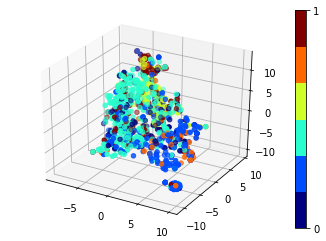

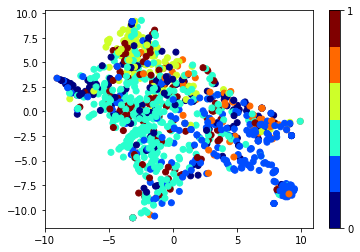

In [8]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


X_embedded = TSNE(n_components=3).fit_transform(training_Xs)

vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
vis_z = X_embedded[:, 2]

sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap("jet", 6))
sm.set_array([])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vis_x, vis_y, vis_z, c=training_predominant_classes, cmap=plt.cm.get_cmap("jet", 6))
fig.colorbar(sm, ticks=range(6))

fig2 =plt.figure()
bx = fig2.add_subplot(111)
bx.scatter(vis_x, vis_y, c=training_predominant_classes, cmap=plt.cm.get_cmap("jet", 6))
fig2.colorbar(sm, ticks=range(6))

plt.show()

# SVM

### Tuning of the hyper-parameters
We use the best configuration of the word2vec model to determine also the hyper-parameters of the SVM classifier.  
Also in this case, for each of the parameters combination we run a 5-fold cross validation on the training set.  
At the end, we use set of parameters which maximizes the f1-score.

In [9]:
def inner_svm_cross_process(combination_parameters, X_train, y_train):
    c_value, gamma_value, kernel_value = combination_parameters

    innerf1 = []
    skf = model_selection.StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    for train_indexes, test_indexes in skf.split(X_train, y_train):
        
        X2_train, X2_test = divide_sets_by_index(X_train, train_indexes, test_indexes)
        y2_train, y2_test = divide_sets_by_index(y_train, train_indexes, test_indexes)

        sclf = SVC(kernel=kernel_value, C=c_value, gamma=gamma_value)
        sclf.fit(X2_train, y2_train)
        ipred = sclf.predict(X2_test)
        
        innerf1.append(metrics.f1_score(ipred, y2_test, average="macro"))
                         
    return combination_parameters, np.mean(innerf1) 

In [10]:
# Values of C which I have to test
Cvalues = [1e-02, 1e-01, 1e00, 1e01, 1e02]

# Values of Gamma which I have to test
Gammavalues = [1e-02, 1e-01, 1e00, 1e01, 1e02]

# Kernels
Kernels = ['rbf', 'poly']

# Get all possibile combination of WindowSize, FeaturesSize, Samples
combination_parameters = list(itertools.product(Cvalues, Gammavalues, Kernels))

X_train = preprocess_w2v_cells(w2v_mapper, training_sentences_splitted)
y_train = training_predominant_classes

# run in parallel cross validation
with Pool(processes=4) as pool:
    combination_and_scores = pool.map(partial(inner_svm_cross_process,
                                              X_train=X_train,
                                              y_train=y_train),
                                      combination_parameters)
    
best_svm_parameters = get_best_combination(combination_and_scores)
print("best_svm_parameters", best_svm_parameters)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


best_svm_parameters (0.1, 10.0, 'poly')


## Train SVM with the final set of parameters

In [11]:
best_c, best_gamma, best_kernel = best_svm_parameters
clf = SVC(C=best_c, kernel=best_kernel, gamma=best_gamma)
model = clf.fit(X_train, y_train)

## Test the model

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_Xs = preprocess_w2v_cells(w2v_mapper, test_sentences_splitted)
results = model.predict(test_Xs)

acc = accuracy_score(test_predominant_classes, results)
precision = precision_score(test_predominant_classes, results, average="macro")
recall = recall_score(test_predominant_classes, results, average="macro")
f1_score = f1_score(test_predominant_classes, results, average="macro")

print("accuracy", acc)
print("f1", f1_score)
print("precision", precision)
print("recall", recall)

accuracy 0.6172248803827751
f1 0.49146596283050453
precision 0.6309916650419185
recall 0.4965470242035707
